## Installing Libraries

In [20]:
!pip install pytesseract
!pip install streamlit
!pip install easyocr
!pip install transformers
!pip install matplotlib
!pip install opencv-python
!pip install cdifflib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/d9/64/7fdfb9386511cd6805451e012c537073a79a958a58795c4e602e538c388c/opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pi

## 1. Text Extraction

In [46]:
import os
import json
import cv2
from PIL import Image
import easyocr
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import pytesseract
import numpy as np
# Load the OCR models
reader = easyocr.Reader(['en'])  # Load the English language model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# Define a function to extract text using PyTesseract
def extract_text_pytesseract(image_file):
    image = cv2.imread(image_file)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb)
    results = pytesseract.image_to_data(pil_image, output_type=pytesseract.Output.DICT)
    return ' '.join(results['text'])

# Define a function to extract text using EasyOCR
def extract_text_easyocr(image_file):
    image = cv2.imread(image_file)
    pil_image = Image.fromarray(image)
    np_array = np.array(pil_image)
    result_easyocr = reader.readtext(np_array)
    return ' '.join([res[1] for res in result_easyocr])

# Define a function to extract text using TrOCR
def extract_text_trocr(image_file):
    image = Image.open(image_file).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

# Create a dictionary to store the results
results = {}

from tqdm import tqdm

# Iterate over all 75 images
results = {}

for filename in tqdm(os.listdir('selected_images'), desc='Processing images', unit='images'):
    image_file = os.path.join('selected_images', filename)
    pytesseract_text = extract_text_pytesseract(image_file)
    easyocr_text = extract_text_easyocr(image_file)
    trocr_text = extract_text_trocr(image_file)

    results[filename] = {}
    # Store the result
    results[filename]["pytesseract"] = pytesseract_text
    results[filename]["easyocr"] = easyocr_text
    results[filename]["trocr"] = trocr_text


# Create a JSON file with the final results
with open('ocr_results.json', 'w') as f:
    json.dump([{'image_name': filename, 'text': text} for filename, text in results.items()], f, indent=4)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing images:   0%|                                                                                                                                                                                                                      | 0/75 [00:00<?, ?images/s]/home/mgl/interviews_question/env/lib/python3.11/site-packages/transforme

## 2. Manual inspection, loading/updating  ocr_result.json on streamlit GUI app to fix text conflix

In [48]:
! streamlit run app.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.18.47:8501

^C
  Stopping...


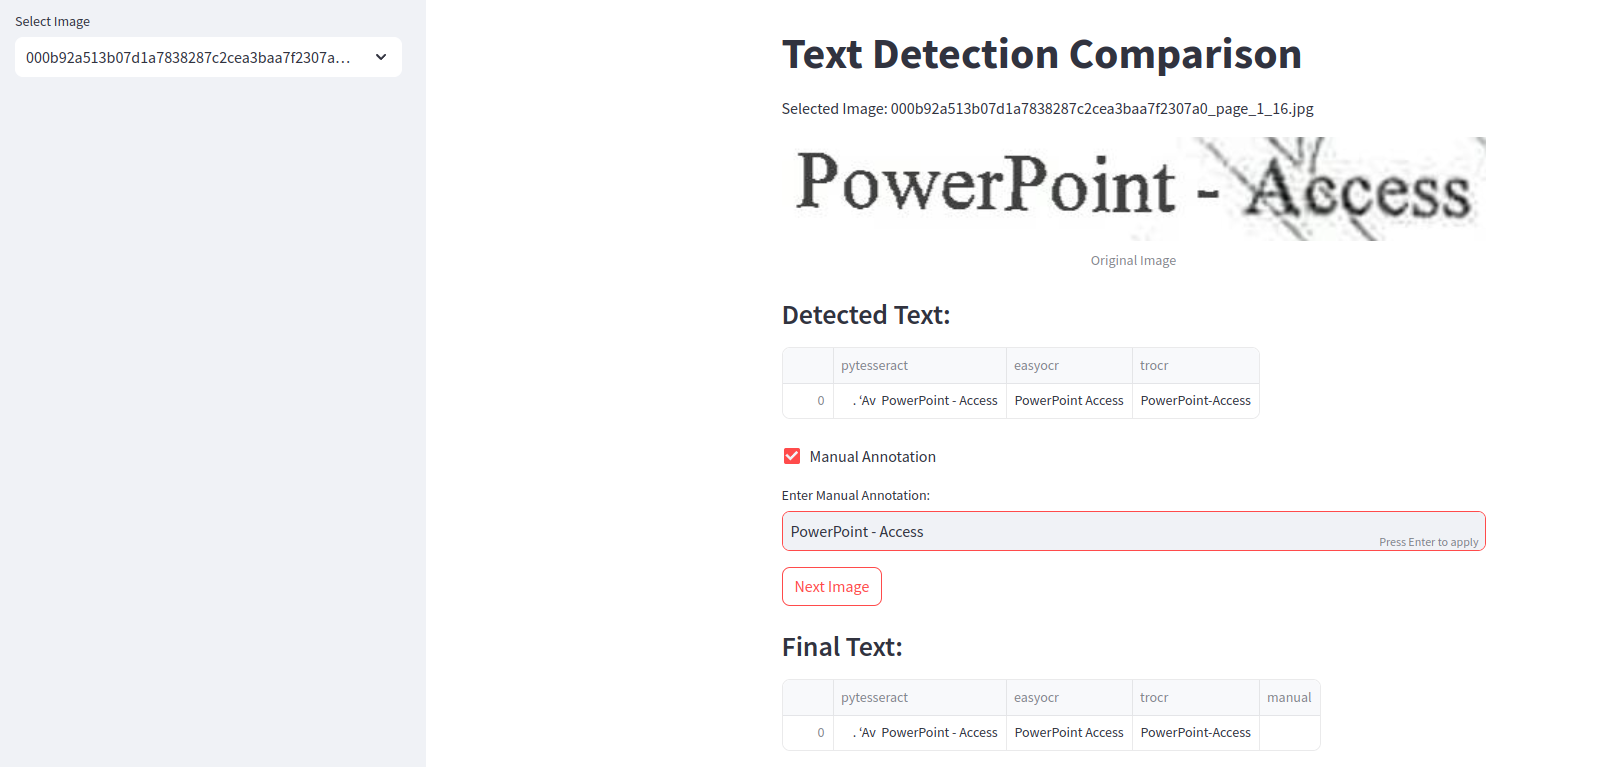

## 3. Similarity approch, the closest to the manual annotated text is the winner

In [49]:
import json
from difflib import SequenceMatcher

def string_similarity_voting_system(json_data):
    results = []
    for item in json_data:
        pytesseract_output = item["text"]["pytesseract"]
        easyocr_output = item["text"]["easyocr"]
        trocr_output = item["text"]["trocr"]
        manual_output = item["text"]["manual"]

        # Calculate string similarity scores
        pytesseract_similarity = SequenceMatcher(None, pytesseract_output, manual_output).ratio()
        easyocr_similarity = SequenceMatcher(None, easyocr_output, manual_output).ratio()
        trocr_similarity = SequenceMatcher(None, trocr_output, manual_output).ratio()

        similarities = {"pytesseract": pytesseract_similarity, "easyocr": easyocr_similarity, "trocr": trocr_similarity}

        # Determine the winner
        winner = max(similarities, key=similarities.get)

        # Store the result
        results.append({"image_name": item["image_name"], "text": item["text"][winner]})

    return results


with open("ocr_results.json") as f:
    json_data = json.load(f)

results = string_similarity_voting_system(json_data)

# Create a JSON file with the final results
with open('final_results.json', 'w') as f:
    json.dump(results, f, indent=4)

In [50]:
! cat final_results.json

[
    {
        "image_name": "000b92a513b07d1a7838287c2cea3baa7f2307a0_page_1_16.jpg",
        "text": "PowerPoint Access"
    },
    {
        "image_name": "0029db0b87cd8ea0e8a1c19ba75cca343bf196dd_page_3_2.jpg",
        "text": "Master of Technology (Information Systems) CGPA: 8.7"
    },
    {
        "image_name": "000b92a513b07d1a7838287c2cea3baa7f2307a0_page_1_19.jpg",
        "text": "Languages"
    },
    {
        "image_name": "006f2d3583a5835146032764078a22a5b1d82a34_page_2_6.jpg",
        "text": "Manager \u2014 Industrial loT & Analytics"
    },
    {
        "image_name": "001aed822d7ac999bf36e50069086c2c525c1902_page_1_16.jpg",
        "text": "strategies."
    },
    {
        "image_name": "0029db0b87cd8ea0e8a1c19ba75cca343bf196dd_page_2_31.jpg",
        "text": "Backend : Golang"
    },
    {
        "image_name": "002e36ce81b25b2579f584404d644eea5ed298bd_page_1_36.jpg",
        "text": "and procedures."
    },
    {
        "image_name": "000ed2333452da408fab1e0626